In [153]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
import scipy
import numpy as np
import pandas as pd
import copy
import statsmodels.api as sm

In [154]:
!PYTORCH_ENABLE_MPS_FALLBACK=1

In [155]:
# transform = transforms.Compose([transforms.ToTensor(),
#                               transforms.Normalize((0.1307,), (0.3081,)),
#                               ])

# train_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=True, transform=transform)
# test_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=False, transform=transform)

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1024

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=len(test_dataset),
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [156]:
def crossent_loss(y_hat, y):
    # y_hat has shape (N, 10) for 10 classes, y has shape (N,)
    f = torch.nn.CrossEntropyLoss(reduction='sum')
    return f(y_hat, y)

In [157]:
def probabilties_from_scores(y):
    f = torch.nn.Softmax(dim=1)
    p = f(y)
    return p

In [158]:
def dense_beta_loss(evidential_output, target):
    alphas, betas = evidential_output
    # return loss(alphas/(alphas+betas), target)
    true_alphas = alphas.gather(1,target.view(-1,1))
    true_betas = betas.gather(1,target.view(-1,1))
    return torch.digamma(alphas+betas).sum() - torch.digamma(betas).sum()+torch.digamma(true_betas).sum()-torch.digamma(true_alphas).sum()

def dirichlet_kl_div(alphas, target):
    return torch.lgamma(target.sum(axis=1)) - torch.lgamma(alphas.sum(axis=1)) + torch.lgamma(alphas).sum(axis=1) - torch.lgamma(target).sum(axis=1) + ((target-alphas)*(torch.digamma(target)-torch.digamma(target.sum(axis=1).view(-1,1)))).sum(axis=1)

def dirichlet_loss(alphas, target, regularizer = True):
    true_alphas = alphas.gather(1,target.view(-1,1))
    loss = torch.digamma(alphas.sum(axis=1)).sum() - torch.digamma(true_alphas).sum()
    if regularizer:
        x = torch.ones_like(alphas)*.1
        x[target] = true_alphas
        loss += 0*dirichlet_kl_div(alphas, x).sum()
    return loss

In [159]:
# x = (torch.ones_like(alphas)*.5)
# print(x.shape)
# print(alphas.shape)
# j = torch.arange(x.size(0)).long()
# print(j.shape)
# print(labels_batch.shape)
# x[:, labels_batch] = true_alphas

In [160]:
def evaluate(dataloader, model, device, log=False, regularizer = True):
    correct_count, total_count = 0, 0
    loss = 0
    cross_loss = 0
    for images_batch, labels_batch in dataloader:
        images = images_batch.reshape(images_batch.shape[0], -1)
        # alphas, betas = model(images.to(device))
        # probabilities = alphas/(alphas+betas)
        alphas = model(images.to(device))
        # print(alphas.shape)
        probabilities = torch.nn.functional.normalize(alphas,1)
        # probabilities = probabilties_from_scores(scores)
        # loss += dense_beta_loss((alphas,betas),labels_batch)
        loss += dirichlet_loss(alphas, labels_batch, regularizer = regularizer)
        cross_loss += -torch.log(probabilities.gather(1,labels_batch.view(-1,1))).sum()
        pred_label = probabilities.max(1, keepdim=True)[1]
        correct_count += pred_label.eq(labels_batch.to(device).view_as(pred_label)).sum().item()
        total_count += labels_batch.shape[0]

    if log:
        print("Number Of Images Tested =", total_count)
        print("Model Accuracy =", (correct_count/total_count))

    return correct_count/total_count, loss, cross_loss

In [161]:
class Net(torch.nn.Module):
    def __init__(self, layer_sizes, inference_type='regression'):
        super(Net, self).__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-2)])
        self.output_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.inference_type = inference_type

    def forward(self, x):
        # x = self.input_instance_norm(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.nn.functional.hardtanh_(x) + x
        x = self.output_layer(x)
        if self.inference_type == 'classification':
            x = torch.nn.functional.softmax(x,dim=-1)
        return x

class EvidentialDenseBetaNet(torch.nn.Module):
    def __init__(self, layer_sizes, inference_type='classification'):
        super(EvidentialDenseBetaNet, self).__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-2)])
        self.output_alpha_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.output_beta_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.inference_type = inference_type
        torch.nn.init.zeros_(self.output_alpha_layer.weight)
        torch.nn.init.zeros_(self.output_beta_layer.weight)
        self.output_alpha_layer.bias.data.fill_(np.log(.5))
        self.output_beta_layer.bias.data.fill_(np.log(.5))

    def forward(self, x):
        # x = self.input_instance_norm(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.nn.functional.hardtanh_(x) + x
        alphas = torch.exp(self.output_alpha_layer(x))
        betas = torch.exp(self.output_beta_layer(x))
        return alphas, betas

class EvidentialDirichletNet(torch.nn.Module):
    def __init__(self, layer_sizes, inference_type='classification'):
        super(EvidentialDirichletNet, self).__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-2)])
        self.output_alpha_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.output_beta_layer = torch.nn.Linear(layer_sizes[-2], layer_sizes[-1])
        self.inference_type = inference_type
        torch.nn.init.zeros_(self.output_alpha_layer.weight)
        self.output_alpha_layer.bias.data.fill_(np.log(.5))

    def forward(self, x):
        # x = self.input_instance_norm(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.nn.functional.hardtanh_(x) + x
        alphas = torch.exp(self.output_alpha_layer(x))
        return alphas

In [162]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else "cpu"))
device='cpu'

In [163]:
# model = general_models.FFNetwork([784, 100, 10], 'classification').to(device)
# model = EvidentialDenseBetaNet([784, 200, 100, 10], 'classification').to(device)
model = EvidentialDirichletNet([3072, 200, 200, 100, 10], 'classification').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [164]:
epochs = 100
best_loss = float('inf')
for epoch in range(epochs):
    running_loss = 0

    for images_batch, labels_batch in tqdm(train_dataloader):
        images_batch = images_batch.reshape(images_batch.shape[0], -1)   # Flatten MNIST images into a 784 long vector

        # forward pass
        y_hat = model(images_batch.to(device))
        y = labels_batch.to(device)
        # L = dense_beta_loss(y_hat, y)
        L = dirichlet_loss(y_hat, y)

        # backward pass
        optimizer.zero_grad()
        L.backward()
        # update parameters
        optimizer.step()
        running_loss += L.item()
    training_loss = running_loss/len(train_dataloader)
    #train_accuracy, train_loss = evaluate(train_dataloader, model)
    test_accuracy, test_loss, cross_loss = evaluate(test_dataloader, model, device, regularizer = False)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = copy.deepcopy(model)

    if epoch % 1 == 0:
        print("Epoch {} - Training loss: {}  Test Accuracy: {}  Test Loss: {}  Crossentropy Loss: {}".format(epoch, training_loss, test_accuracy, test_loss, cross_loss))

    # if test_accuracy > .98:
    #     break

100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


Epoch 0 - Training loss: 2709.2007184709823  Test Accuracy: 0.3403  Test Loss: 22952.251953125  Crossentropy Loss: 18873.1484375


100%|██████████| 49/49 [00:26<00:00,  1.88it/s]


Epoch 1 - Training loss: 2123.075068259726  Test Accuracy: 0.3918  Test Loss: 19043.0  Crossentropy Loss: 17546.259765625


100%|██████████| 49/49 [00:22<00:00,  2.14it/s]


Epoch 2 - Training loss: 1794.8948949697067  Test Accuracy: 0.4295  Test Loss: 17116.638671875  Crossentropy Loss: 16436.234375


100%|██████████| 49/49 [00:20<00:00,  2.34it/s]


Epoch 3 - Training loss: 1642.936976841518  Test Accuracy: 0.4461  Test Loss: 16308.59765625  Crossentropy Loss: 15828.931640625


100%|██████████| 49/49 [00:23<00:00,  2.08it/s]


Epoch 4 - Training loss: 1570.2194325972578  Test Accuracy: 0.4616  Test Loss: 15652.65234375  Crossentropy Loss: 15330.3125


100%|██████████| 49/49 [00:14<00:00,  3.27it/s]


Epoch 5 - Training loss: 1471.1820442044004  Test Accuracy: 0.4692  Test Loss: 15216.84375  Crossentropy Loss: 14964.3515625


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 6 - Training loss: 1406.5723254145407  Test Accuracy: 0.4815  Test Loss: 15119.90625  Crossentropy Loss: 14883.630859375


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 7 - Training loss: 1344.9699408083545  Test Accuracy: 0.4846  Test Loss: 14907.38671875  Crossentropy Loss: 14692.2265625


100%|██████████| 49/49 [00:15<00:00,  3.23it/s]


Epoch 8 - Training loss: 1291.8526686065052  Test Accuracy: 0.4904  Test Loss: 14944.76953125  Crossentropy Loss: 14721.822265625


100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


Epoch 9 - Training loss: 1239.7022281568877  Test Accuracy: 0.4859  Test Loss: 14954.02734375  Crossentropy Loss: 14693.154296875


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 10 - Training loss: 1187.6057776626276  Test Accuracy: 0.4931  Test Loss: 14994.9375  Crossentropy Loss: 14715.62109375


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 11 - Training loss: 1139.6618602519134  Test Accuracy: 0.4891  Test Loss: 15164.6171875  Crossentropy Loss: 14912.33203125


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 12 - Training loss: 1100.9471261160713  Test Accuracy: 0.495  Test Loss: 15151.36328125  Crossentropy Loss: 14893.61328125


100%|██████████| 49/49 [00:14<00:00,  3.27it/s]


Epoch 13 - Training loss: 1050.7925701530612  Test Accuracy: 0.4996  Test Loss: 15122.5390625  Crossentropy Loss: 14830.158203125


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 14 - Training loss: 998.6837232940051  Test Accuracy: 0.4988  Test Loss: 15807.71875  Crossentropy Loss: 15138.84375


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Epoch 15 - Training loss: 962.5006078603317  Test Accuracy: 0.4894  Test Loss: 15909.81640625  Crossentropy Loss: 15510.3212890625


100%|██████████| 49/49 [00:15<00:00,  3.26it/s]


Epoch 16 - Training loss: 927.7181022799745  Test Accuracy: 0.4935  Test Loss: 15903.28125  Crossentropy Loss: 15432.2314453125


100%|██████████| 49/49 [00:14<00:00,  3.30it/s]


Epoch 17 - Training loss: 882.9422632334183  Test Accuracy: 0.4913  Test Loss: 16603.06640625  Crossentropy Loss: 15864.193359375


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 18 - Training loss: 852.1426179846939  Test Accuracy: 0.498  Test Loss: 16411.609375  Crossentropy Loss: 15966.916015625


100%|██████████| 49/49 [00:15<00:00,  3.25it/s]


Epoch 19 - Training loss: 808.913235411352  Test Accuracy: 0.4894  Test Loss: 18675.8359375  Crossentropy Loss: 16349.3271484375


100%|██████████| 49/49 [00:14<00:00,  3.33it/s]


Epoch 20 - Training loss: 765.5010662468112  Test Accuracy: 0.4952  Test Loss: 17592.234375  Crossentropy Loss: 16542.982421875


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 21 - Training loss: 731.8074577487245  Test Accuracy: 0.4852  Test Loss: 18089.58984375  Crossentropy Loss: 16897.515625


100%|██████████| 49/49 [00:14<00:00,  3.34it/s]


Epoch 22 - Training loss: 707.8978495695153  Test Accuracy: 0.486  Test Loss: 18559.765625  Crossentropy Loss: 17262.845703125


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 23 - Training loss: 668.3390066964286  Test Accuracy: 0.4921  Test Loss: 18873.58203125  Crossentropy Loss: 17467.5234375


100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


Epoch 24 - Training loss: 633.3745216836735  Test Accuracy: 0.4845  Test Loss: 20170.21875  Crossentropy Loss: 17948.5390625


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 25 - Training loss: 612.5139309630102  Test Accuracy: 0.4726  Test Loss: 20385.53125  Crossentropy Loss: 18686.537109375


100%|██████████| 49/49 [00:14<00:00,  3.33it/s]


Epoch 26 - Training loss: 600.2410514987245  Test Accuracy: 0.484  Test Loss: 21547.1015625  Crossentropy Loss: 18478.83203125


100%|██████████| 49/49 [00:14<00:00,  3.33it/s]


Epoch 27 - Training loss: 553.7745735012755  Test Accuracy: 0.4782  Test Loss: 21102.1796875  Crossentropy Loss: 19119.732421875


100%|██████████| 49/49 [00:15<00:00,  3.26it/s]


Epoch 28 - Training loss: 529.4058314732143  Test Accuracy: 0.4836  Test Loss: 23217.359375  Crossentropy Loss: 19407.57421875


100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


Epoch 29 - Training loss: 496.97222775829084  Test Accuracy: 0.4745  Test Loss: 22680.3359375  Crossentropy Loss: 19822.3203125


100%|██████████| 49/49 [00:14<00:00,  3.36it/s]


Epoch 30 - Training loss: 477.82446787308675  Test Accuracy: 0.4753  Test Loss: 24181.09375  Crossentropy Loss: 20420.40234375


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 31 - Training loss: 445.31636639030614  Test Accuracy: 0.4762  Test Loss: 24319.8515625  Crossentropy Loss: 20747.3125


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 32 - Training loss: 430.56303810586735  Test Accuracy: 0.4795  Test Loss: 30887.5234375  Crossentropy Loss: 20886.765625


100%|██████████| 49/49 [00:14<00:00,  3.34it/s]


Epoch 33 - Training loss: 415.5688576211735  Test Accuracy: 0.4728  Test Loss: 35661.25  Crossentropy Loss: 21922.298828125


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Epoch 34 - Training loss: 400.2151028380102  Test Accuracy: 0.4751  Test Loss: 28347.8828125  Crossentropy Loss: 22021.408203125


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Epoch 35 - Training loss: 360.4000916772959  Test Accuracy: 0.468  Test Loss: 29600.15625  Crossentropy Loss: 22322.251953125


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 36 - Training loss: 357.05984933035717  Test Accuracy: 0.4749  Test Loss: 32978.390625  Crossentropy Loss: 22735.287109375


100%|██████████| 49/49 [00:14<00:00,  3.30it/s]


Epoch 37 - Training loss: 323.6791095344388  Test Accuracy: 0.4723  Test Loss: 32501.2421875  Crossentropy Loss: 23178.98046875


100%|██████████| 49/49 [00:14<00:00,  3.27it/s]


Epoch 38 - Training loss: 299.82027264030614  Test Accuracy: 0.471  Test Loss: 60721.2890625  Crossentropy Loss: 23919.42578125


100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


Epoch 39 - Training loss: 313.7612205038265  Test Accuracy: 0.471  Test Loss: 39501.8984375  Crossentropy Loss: 24313.890625


100%|██████████| 49/49 [00:14<00:00,  3.38it/s]


Epoch 40 - Training loss: 284.069993622449  Test Accuracy: 0.474  Test Loss: 37998.8828125  Crossentropy Loss: 24550.87109375


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 41 - Training loss: 258.98060825892856  Test Accuracy: 0.475  Test Loss: 61117.06640625  Crossentropy Loss: 25154.6328125


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 42 - Training loss: 236.6061463647959  Test Accuracy: 0.4702  Test Loss: 55222.77734375  Crossentropy Loss: 25692.8125


100%|██████████| 49/49 [00:14<00:00,  3.36it/s]


Epoch 43 - Training loss: 219.5174784757653  Test Accuracy: 0.4647  Test Loss: 48650.6484375  Crossentropy Loss: 26120.45703125


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 44 - Training loss: 228.36170679209184  Test Accuracy: 0.4634  Test Loss: 55791.3984375  Crossentropy Loss: 26731.142578125


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 45 - Training loss: 210.80450813137756  Test Accuracy: 0.4668  Test Loss: 55163.0078125  Crossentropy Loss: 27066.85546875


100%|██████████| 49/49 [00:14<00:00,  3.30it/s]


Epoch 46 - Training loss: 200.63950892857142  Test Accuracy: 0.4618  Test Loss: 60528.796875  Crossentropy Loss: 27412.341796875


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 47 - Training loss: 184.07372050382654  Test Accuracy: 0.4717  Test Loss: 111510.3125  Crossentropy Loss: 27869.32421875


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 48 - Training loss: 174.07136878188774  Test Accuracy: 0.466  Test Loss: 117085.609375  Crossentropy Loss: 28608.26171875


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 49 - Training loss: 168.50538105867346  Test Accuracy: 0.458  Test Loss: 74158.578125  Crossentropy Loss: 29089.44140625


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 50 - Training loss: 172.4822225765306  Test Accuracy: 0.4588  Test Loss: 106517.25  Crossentropy Loss: 29609.029296875


100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Epoch 51 - Training loss: 160.98280054209184  Test Accuracy: 0.4628  Test Loss: 110886.3515625  Crossentropy Loss: 29886.533203125


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 52 - Training loss: 144.82421875  Test Accuracy: 0.459  Test Loss: 248269.6875  Crossentropy Loss: 30571.6328125


100%|██████████| 49/49 [00:14<00:00,  3.35it/s]


Epoch 53 - Training loss: 174.02804129464286  Test Accuracy: 0.4587  Test Loss: 237144.578125  Crossentropy Loss: 30753.22265625


100%|██████████| 49/49 [00:15<00:00,  3.21it/s]


Epoch 54 - Training loss: 167.6646803252551  Test Accuracy: 0.4569  Test Loss: 204394.21875  Crossentropy Loss: 30773.736328125


100%|██████████| 49/49 [00:14<00:00,  3.42it/s]


Epoch 55 - Training loss: 135.03659119897958  Test Accuracy: 0.4649  Test Loss: 91501.9375  Crossentropy Loss: 30789.376953125


100%|██████████| 49/49 [00:14<00:00,  3.42it/s]


Epoch 56 - Training loss: 96.93783880739795  Test Accuracy: 0.4596  Test Loss: 144484.421875  Crossentropy Loss: 31791.57421875


100%|██████████| 49/49 [00:14<00:00,  3.31it/s]


Epoch 57 - Training loss: 88.98397640306122  Test Accuracy: 0.4629  Test Loss: 164036.859375  Crossentropy Loss: 32082.041015625


100%|██████████| 49/49 [00:14<00:00,  3.43it/s]


Epoch 58 - Training loss: 84.24354272959184  Test Accuracy: 0.4647  Test Loss: 429279.0  Crossentropy Loss: 32606.001953125


100%|██████████| 49/49 [00:14<00:00,  3.39it/s]


Epoch 59 - Training loss: 81.84088010204081  Test Accuracy: 0.4601  Test Loss: 240023.53125  Crossentropy Loss: 33507.4375


100%|██████████| 49/49 [00:14<00:00,  3.37it/s]


Epoch 60 - Training loss: 90.14706234056122  Test Accuracy: 0.4638  Test Loss: 5922094.5  Crossentropy Loss: 33573.45703125


100%|██████████| 49/49 [00:14<00:00,  3.39it/s]


Epoch 61 - Training loss: 87.49992028061224  Test Accuracy: 0.4565  Test Loss: 3172681.5  Crossentropy Loss: 34545.5546875


100%|██████████| 49/49 [00:14<00:00,  3.36it/s]


Epoch 62 - Training loss: 79.37041613520408  Test Accuracy: 0.4588  Test Loss: 3787840.25  Crossentropy Loss: 34661.546875


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 63 - Training loss: 85.16681281887755  Test Accuracy: 0.4527  Test Loss: 1004927.0  Crossentropy Loss: 35047.38671875


100%|██████████| 49/49 [00:14<00:00,  3.37it/s]


Epoch 64 - Training loss: 95.5111009247449  Test Accuracy: 0.4619  Test Loss: 963744.8125  Crossentropy Loss: 35583.484375


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 65 - Training loss: 135.48963647959184  Test Accuracy: 0.4557  Test Loss: 291329.1875  Crossentropy Loss: 35465.94140625


100%|██████████| 49/49 [00:14<00:00,  3.33it/s]


Epoch 66 - Training loss: 166.54045758928572  Test Accuracy: 0.4485  Test Loss: 1088692.75  Crossentropy Loss: 35676.796875


100%|██████████| 49/49 [00:14<00:00,  3.38it/s]


Epoch 67 - Training loss: 131.12316645408163  Test Accuracy: 0.4558  Test Loss: 2802187.75  Crossentropy Loss: 35273.9375


100%|██████████| 49/49 [00:14<00:00,  3.32it/s]


Epoch 68 - Training loss: 96.65503427933673  Test Accuracy: 0.4538  Test Loss: 3276477.0  Crossentropy Loss: 35884.56640625


100%|██████████| 49/49 [00:14<00:00,  3.37it/s]


Epoch 69 - Training loss: 102.43437101403062  Test Accuracy: 0.4646  Test Loss: 371783.5625  Crossentropy Loss: 35981.5859375


100%|██████████| 49/49 [00:14<00:00,  3.40it/s]


Epoch 70 - Training loss: 70.0712890625  Test Accuracy: 0.4633  Test Loss: 556464.5  Crossentropy Loss: 36054.98046875


100%|██████████| 49/49 [00:14<00:00,  3.36it/s]


Epoch 71 - Training loss: 48.89144212372449  Test Accuracy: 0.4567  Test Loss: 1544866.375  Crossentropy Loss: 37016.05078125


100%|██████████| 49/49 [00:14<00:00,  3.40it/s]


Epoch 72 - Training loss: 33.38799426020408  Test Accuracy: 0.4606  Test Loss: 1098990.375  Crossentropy Loss: 37483.0625


100%|██████████| 49/49 [00:14<00:00,  3.36it/s]


Epoch 73 - Training loss: 22.426319355867346  Test Accuracy: 0.4624  Test Loss: 542131.25  Crossentropy Loss: 37605.61328125


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


KeyboardInterrupt: 

In [165]:
for images_batch, labels_batch in test_dataloader:
    images = images_batch.reshape(images_batch.shape[0], -1)
    alphas = best_model(images.to(device)).detach()
probs = torch.nn.functional.normalize(alphas,1)
true_alphas = alphas.gather(1,labels_batch.view(-1,1).to(device))
evidences = alphas.sum(axis=1)
losses = torch.digamma(alphas.sum(axis=1)) - torch.digamma(true_alphas).flatten()
entropies = -(probs*probs.log()).sum(axis=1)

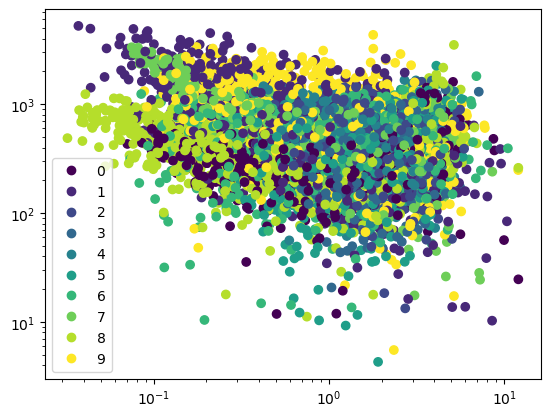

In [168]:
scatter = plt.scatter(losses, evidences, c=labels_batch, alpha=1)
plt.yscale('log')
plt.xscale('log')
plt.legend(*scatter.legend_elements())

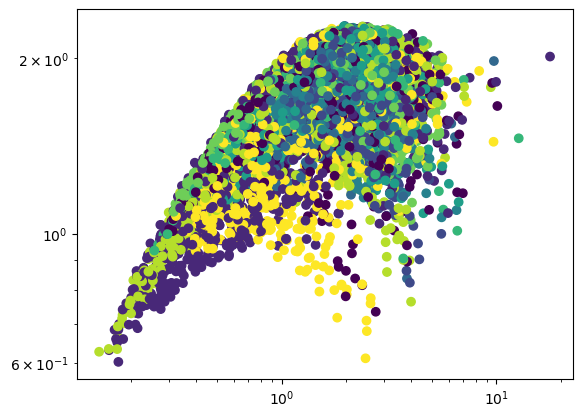

In [ ]:
plt.scatter(losses, entropies, c=labels_batch)
plt.yscale('log')
plt.xscale('log')

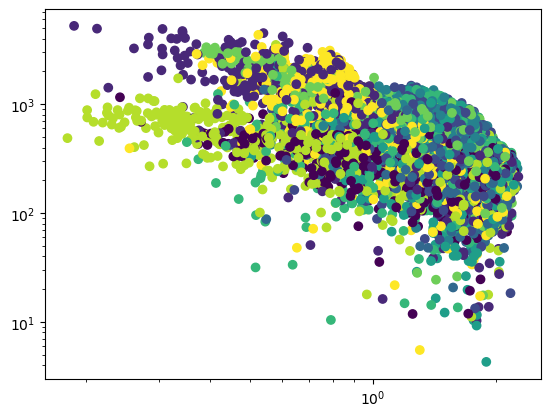

In [167]:
plt.scatter(entropies, evidences, c=labels_batch, alpha=1)
plt.yscale('log')
plt.xscale('log')

In [ ]:
true_alphas

tensor([[443.8360],
        [624.0986],
        [723.0762],
        ...,
        [544.6868],
        [273.7161],
        [581.1541]])

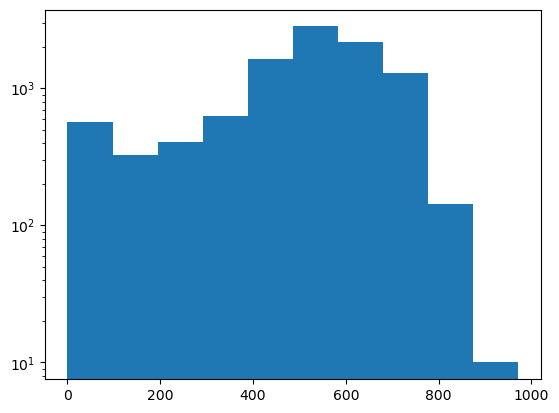

In [ ]:
plt.hist((true_alphas).view(-1).cpu().detach().numpy())
plt.yscale('log')

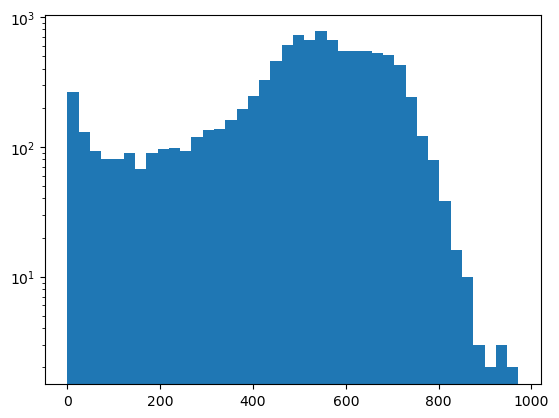

In [ ]:
plt.hist(true_alphas.view(-1).cpu().detach().numpy(), bins=40)
plt.yscale('log')

In [ ]:
scatter = plt.scatter((true_alphas/(true_alphas+true_betas)).view(-1).cpu().detach().numpy(),(true_alphas+true_betas).view(-1).cpu().detach().numpy(), c=labels_batch.numpy())
plt.yscale('log')
plt.legend(*scatter.legend_elements(), title="Classes")

NameError: name 'true_betas' is not defined

In [ ]:
labels_batch[((true_alphas>400)*( (true_alphas/(true_alphas+true_betas))<.8)*(.2<(true_alphas/(true_alphas+true_betas)))).view(-1)]

tensor([], dtype=torch.int64)

In [ ]:
labels_batch[((true_alphas<100)*((true_alphas/(true_alphas+true_betas))<.8)*(.2<(true_alphas/(true_alphas+true_betas)))).view(-1)]

tensor([3, 7, 7, 5, 3, 3, 9, 0, 6, 9, 2, 2, 7, 3, 2, 5, 1, 9, 3, 4, 5, 2, 9, 8,
        5, 7, 5, 9, 8, 8, 4, 3, 4, 2, 3, 9, 5, 5, 7, 4, 8, 7, 3, 9, 6, 2, 2, 2,
        5, 5, 8, 8, 8, 2, 2, 5, 8, 4, 8, 6, 4, 5, 3, 5, 2, 9, 7, 5, 5, 7, 2, 2,
        0, 9, 6, 2, 1, 6, 7, 4, 7, 3, 9, 3, 7, 8, 8, 6, 5, 8, 8, 3, 8, 9, 7, 9,
        5, 2, 4, 3, 4, 7, 4, 8, 5, 9, 3, 7, 9, 3, 3, 8, 5, 5, 4, 4, 7, 6, 6, 7,
        8, 2, 3, 9, 8, 9, 7, 7, 6, 3, 6, 9, 3, 5, 3, 5, 2, 6, 9, 1, 7, 6, 8, 7,
        5, 7, 5, 7, 5, 3, 8, 5, 2, 2, 0, 2, 8, 9, 4, 7, 0, 5, 7, 5, 3, 2, 5, 3,
        4, 8, 2, 9, 4, 2, 9, 5, 0, 9, 2, 1, 4, 6, 7, 3, 3, 9])

In [ ]:
a,b =model(torch.randn(1,784).to(device))

In [ ]:
a/(a+b)

tensor([[9.5481e-01, 2.9279e-03, 9.8478e-01, 9.9282e-01, 1.8893e-01, 8.7521e-02,
         8.6043e-04, 9.6548e-01, 7.5512e-01, 1.2076e-02]],
       grad_fn=<DivBackward0>)

In [ ]:
a+b

tensor([[ 1.3016,  0.6483,  0.7193,  0.3592,  7.6514,  1.8314, 12.3111,  0.8062,
          3.3017,  0.5943]], grad_fn=<AddBackward0>)

In [ ]:
labels_batch.numpy()

array([5, 8, 3, ..., 6, 0, 9])

In [ ]:
(alphas/(alphas+betas)).sum(axis=1).var()**.5

tensor(0.0836, grad_fn=<PowBackward0>)

(array([ 5914.,  3482.,   398.,   400.,  1142., 37007., 39177.,  6715.,
         3977.,  1788.]),
 array([-0.9655295 ,  0.34486392,  1.65525734,  2.9656508 ,  4.27604437,
         5.5864377 ,  6.89683104,  8.20722485,  9.51761818, 10.82801151,
        12.13840485]),
 <BarContainer object of 10 artists>)

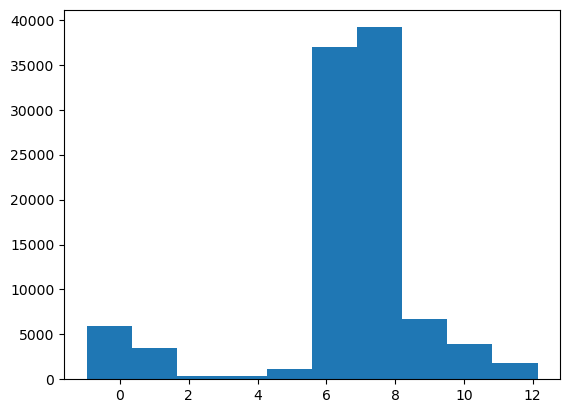

In [ ]:
plt.hist(np.log(betas.cpu().detach().numpy().flatten()))

In [ ]:
true_probs = true_alphas/(true_alphas+true_betas)

In [ ]:
probs = alphas/(alphas+betas)
evidence = alphas+betas

In [ ]:
losses = torch.digamma(alphas+betas).sum(axis=1) - torch.digamma(betas).sum(axis=1)+torch.digamma(true_betas).flatten()-torch.digamma(true_alphas).flatten()

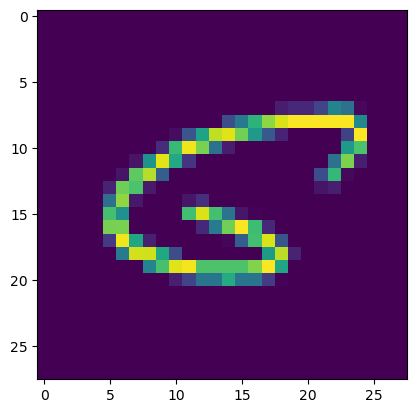

In [ ]:
plt.imshow(images[losses.argmax()].view(28,28))
plt.show()

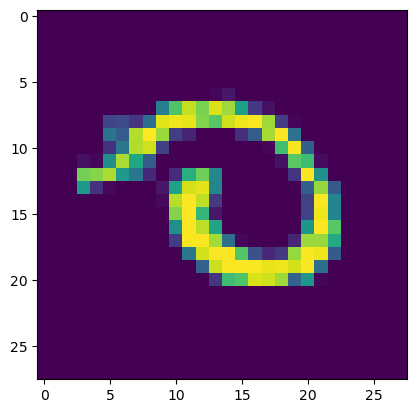

tensor(0)
tensor([0.0094, 0.0075, 0.1283, 0.3541, 0.0124, 0.0188, 0.0267, 0.0105, 0.2423,
        0.1899])
tensor(1.2977)


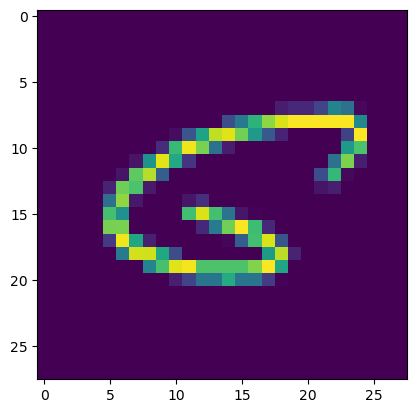

tensor(6)
tensor([0.0073, 0.0060, 0.0028, 0.0176, 0.0018, 0.8696, 0.0078, 0.0037, 0.0696,
        0.0138])
tensor(3.8510)


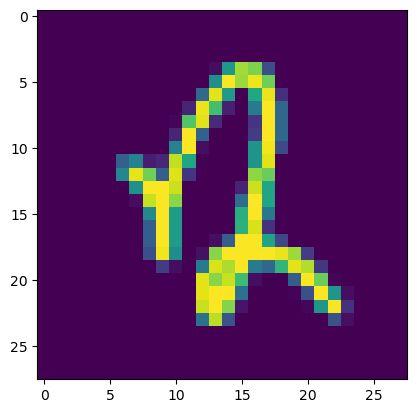

tensor(2)
tensor([0.0242, 0.0160, 0.0145, 0.0022, 0.6467, 0.0097, 0.0791, 0.0227, 0.0322,
        0.1529])
tensor(2.7549)


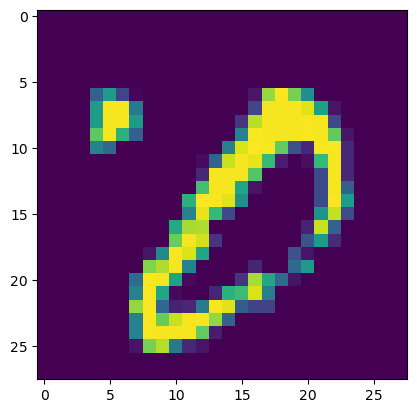

tensor(0)
tensor([0.0220, 0.0778, 0.0303, 0.3887, 0.0041, 0.0033, 0.0035, 0.0105, 0.4452,
        0.0147])
tensor(1.8726)


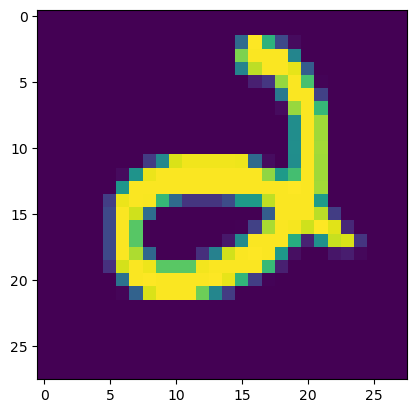

tensor(2)
tensor([0.0364, 0.0369, 0.0215, 0.3155, 0.0372, 0.0363, 0.4945, 0.0039, 0.0044,
        0.0134])
tensor(1.9174)


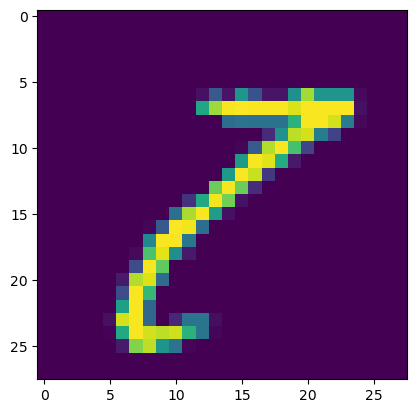

tensor(7)
tensor([0.0222, 0.0308, 0.0158, 0.2457, 0.0036, 0.0171, 0.0011, 0.0220, 0.6166,
        0.0251])
tensor(1.9399)


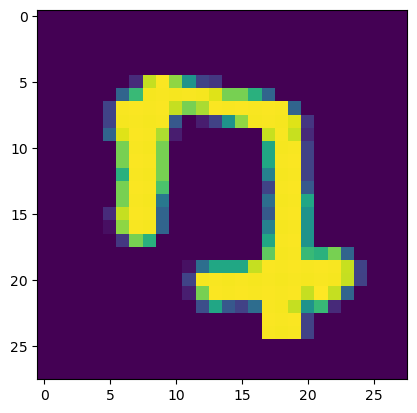

tensor(7)
tensor([0.3467, 0.0169, 0.1466, 0.0334, 0.0495, 0.0380, 0.0738, 0.0526, 0.1092,
        0.1333])
tensor(0.9099)


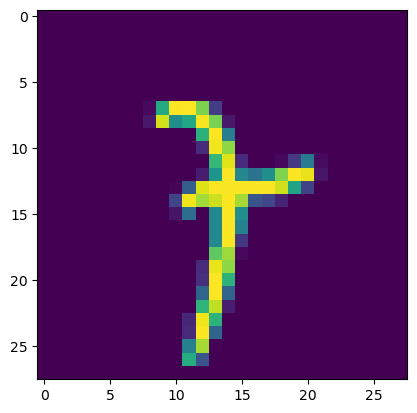

tensor(7)
tensor([0.0109, 0.0806, 0.0074, 0.0293, 0.0247, 0.0174, 0.0109, 0.0278, 0.6968,
        0.0943])
tensor(1.8925)


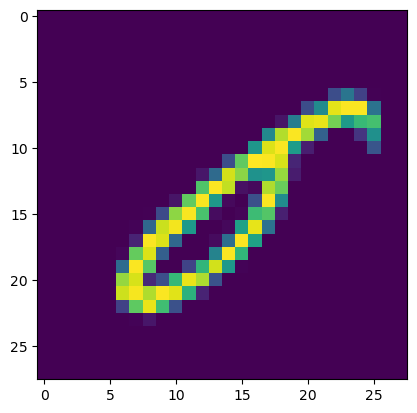

tensor(0)
tensor([0.0489, 0.0671, 0.0928, 0.0306, 0.0362, 0.2019, 0.0686, 0.0038, 0.4412,
        0.0089])
tensor(1.1294)


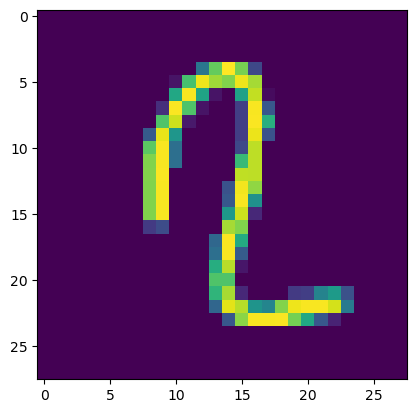

tensor(2)
tensor([0.0072, 0.0304, 0.0139, 0.0040, 0.0129, 0.0113, 0.0074, 0.0034, 0.8695,
        0.0400])
tensor(5.4287)


In [ ]:
for idx in losses.topk(10)[1]:
    image = images[idx].view(28,28)
    label = labels_batch[idx]
    plt.imshow(image)
    plt.show()
    print(label)
    print(probs[idx])
    print(evidences[idx])